# **INPUT LIBRARY**

In [ ]:
import librosa
import librosa.display
import pandas as pd
import os
import numpy as np
from scipy.fftpack import dct
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import metrics
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
# from google.colab import drive
import ctypes
from ctypes import util
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side

# **PROSES MFCC**

**Fungis Pre-Emphasis**

In [ ]:
# Fungsi pre-emphasis
def pre_emphasis(signal, coefficient=0.97):
    return np.append(signal[0], signal[1:] - coefficient * signal[:-1])

**Fungsi Frame-Blocking**

In [ ]:
# Fungsi framing
def framing(signal, sample_rate, frame_length=0.025,
            frame_step=0.010):
    nsamples_signal = len(signal)
    nsamples_frame = int(round(frame_length * sample_rate))
    nsamples_stride = int(round(frame_step * sample_rate))
    n_frames = int(np.ceil((nsamples_signal - nsamples_frame) / nsamples_stride) + 1)
    nsamples_padding = ((n_frames - 1) * nsamples_stride + nsamples_frame) - nsamples_signal
    z = np.zeros(nsamples_padding)
    signal = np.append(signal, z)
    frames = np.empty((n_frames, nsamples_frame))
    for i in range(n_frames):
        left = i * nsamples_stride
        right = left + nsamples_frame
        frame = signal[left:right]
        frames[i] = frame
    return frames

**Fungsi MFCC**

In [ ]:
# Fungsi untuk mengekstrak fitur MFCC dari file audio
def extract_mfcc(audio_file, sr=44100, frame_length=0.025, frame_step=0.010, nfilt=40, num_ceps=12):
    y, _ = librosa.load(audio_file, sr=sr)

    # Normalize
    y_norm = librosa.util.normalize(y)

    # Pre-emphasis
    y_pre_emphasis = pre_emphasis(y_norm)

    # Framing
    frames = framing(y_pre_emphasis, sr, frame_length, frame_step)

    # Hamming window
    frames *= np.hanning(len(frames[0]))

    # FFT
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Mel filter bank
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sr)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    # Discrete Cosine Transform (DCT) for MFCC
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps + 1)]

    return np.mean(mfcc, axis=0)

**Dataset**

In [ ]:
# Directory tempat file audio Anda disimpan
dataset = '/content/drive/MyDrive/REVISI SKRIPSI/Dataset Pertama'

In [ ]:
dataset_kedua = '/content/drive/MyDrive/REVISI SKRIPSI/Dataset Kedua'

**Inisialisasi Dataset**

In [ ]:
data = []

# Loop melalui setiap direktori label
for label_folder in os.listdir(dataset):
    label_dir = os.path.join(dataset, label_folder)
    if os.path.isdir(label_dir):
        # Loop melalui file-file audio di dalam setiap label
        for file in os.listdir(label_dir):
            if file.endswith(".wav"):
                audio_file = os.path.join(label_dir, file)
                mfcc_features = extract_mfcc(audio_file)
                # Menambahkan ID ke data
                features_list = list(mfcc_features) + [label_folder]
                data.append(features_list)

In [ ]:
# Inisialisasi data
data = []

# Loop melalui setiap direktori ID
for id_folder in os.listdir(dataset):
    id_dir = os.path.join(dataset, id_folder)
    if os.path.isdir(id_dir):
        # Loop melalui setiap label di dalam direktori ID
        for label in os.listdir(id_dir):
            label_dir = os.path.join(id_dir, label)
            if os.path.isdir(label_dir):
                # Loop melalui file-file audio di dalam setiap label
                for file in os.listdir(label_dir):
                    if file.endswith(".wav"):
                        audio_file = os.path.join(label_dir, file)
                        mfcc_features = extract_mfcc(audio_file)
                        # Menambahkan ID ke data
                        data.append(list(mfcc_features) + [id_folder] + [label])

**Menyimpan Hasil MFCC ke CSV**

In [ ]:
# Mengubah data ke dalam DataFrame
df = pd.DataFrame(data, columns=[f'mfcc_{i}' for i in range(1, 13)] + ['id', 'label'])

# Menggabungkan kolom ID dan label menjadi satu kolom id_label
df['id_label'] = df['id'] + '_' + df['label']

# Menyimpan DataFrame yang sudah diubah ke dalam file CSV
df.to_csv('/content/drive/MyDrive/Skripsi/mfcc/backup_4_label.csv', index=False)

In [ ]:
 # Mengubah data ke dalam DataFrame
df = pd.DataFrame(data, columns=[f'mfcc_{i}' for i in range(1, 13)] + ['target'])

# Menyimpan DataFrame yang sudah diubah ke dalam file CSV
df.to_csv('/content/drive/MyDrive/REVISI SKRIPSI/dataset_pertama.csv', index=False)

In [ ]:
# Menyimpan DataFrame ke dalam file Excel
wb = Workbook()
ws = wb.active

# Menulis data ke dalam worksheet
for r in dataframe_to_rows(df, index=True, header=True):
    ws.append(r)

# Menambahkan border di antara setiap sel
for row in ws.iter_rows():
    for cell in row:
        cell.border = Border(left=Side(style='thin'),
                             right=Side(style='thin'),
                             top=Side(style='thin'),
                             bottom=Side(style='thin'))

# Menyimpan file Excel
wb.save('/content/drive/MyDrive/Persiapan Sidang/inisialisasi data label.xlsx')

# **KLASIFIKASI SVM**

## **A. Split Data**

In [ ]:
read_csv = pd.read_csv('/content/drive/MyDrive/REVISI SKRIPSI/dataset_pertama.csv')

In [ ]:
read_csv

mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0    134.007563 -10.597640   7.266465  -3.754714 -13.808333   2.155736   
1     50.750191  -5.598916  32.949004 -22.501260  14.779131 -19.538301   
2    122.293842 -12.814458  12.493625 -10.989077 -15.963840   1.330859   
3    126.803849  -0.053941   8.270297  -6.800313 -13.392560  -0.899367   
4     10.468602   9.117828  -8.683499  -1.466168  24.753077 -21.531051   
..          ...        ...        ...        ...        ...        ...   
145   36.427943  25.707284   8.212668  10.450583  -5.248485 -11.510404   
146   43.954271   6.456048   2.131374  -9.353882 -17.369689  -7.557169   
147   55.782108  26.974924  -5.329280  -1.423440  -9.777956  -8.758294   
148   26.584968  -8.043035  -4.178721  -0.592769 -15.964644  -9.010896   
149   19.589333   9.885163 -20.071891 -13.235444 -15.691194 -10.111671   

        mfcc_7     mfcc_8     mfcc_9    mfcc_10   mfcc_11   mfcc_12  target  
0   -12.878377  -4.975601   6.321278  -2.777375 -6.506576 -1.876924   Hilmi  
1     7.961897 -11.957439   7.594936 -14.929685  5.006317 -1.295943   Hilmi  
2   -17.650124  -3.014083   3.925209  -6.664020 -1.170681 -0.027291   Hilmi  
3   -14.874580   0.227556   7.045879  -7.464138 -5.668817 -0.148281   Hilmi  
4     2.124193  -6.581121  11.937312 -18.942954  5.763798  0.569468   Hilmi  
..         ...        ...        ...        ...       ...       ...     ...  
145  -6.744978  -9.246621  -3.982937 -10.705474 -6.795224 -6.532252  Random  
146 -15.326618 -16.521912   1.466365  -6.723767  1.931086  2.092220  Random  
147  -1.948076  -6.980490  -0.893085  -4.223947 -4.055362 -5.809257  Random  
148  -4.953900 -11.460907  -0.344327  -4.228080 -1.677582 -2.752977  Random  
149   2.390462  -5.974159  -0.621773  -2.311574  4.188963 -0.232814  Random  

[150 rows x 13 columns]

In [ ]:
# Separate features (MFCC) and labels
X = read_csv.iloc[:, :-1]
y = read_csv['target']

## **B. Data Standartlization**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = SVC(kernel='rbf', C=8, gamma=0.001)
# model = SVC(kernel='linear', C=0.1)

In [ ]:
# Wrap model SVM dengan OneVsOneClassifier
ovo_model = OneVsOneClassifier(model)

# Latih model pada data latih
ovo_model.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_ovo = ovo_model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_pred_ovo, y_test))
print("\nClassification Report:\n", classification_report(y_pred_ovo, y_test))

Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

       Hilmi       1.00      0.86      0.92         7
      Random       1.00      1.00      1.00         7
       Tanti       0.83      1.00      0.91         5
    Vasyilla       1.00      1.00      1.00         7
       Yudha       1.00      1.00      1.00         4

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
# Wrap model SVM dengan OneVsOneClassifier
ovr_model =OneVsRestClassifier(model)

# Latih model pada data latih
ovr_model.fit(X_train, y_train)

# Prediksi pada data uji
y_pred_ovr = ovr_model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_pred_ovr, y_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ovr))

Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

       Hilmi       0.86      1.00      0.92         6
      Random       1.00      1.00      1.00         7
       Tanti       1.00      0.83      0.91         6
    Vasyilla       1.00      1.00      1.00         7
       Yudha       1.00      1.00      1.00         4

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
cm = confusion_matrix(y_test, y_pred_ovo)

# Hitung True Positives (TP) untuk setiap kelas
TP = np.diag(cm)

TN = []
FP = []
FN = []
for i in range(len(cm)):
    temp = np.delete(cm, i, 0)  # hapus baris ke-i
    temp = np.delete(temp, i, 1)  # hapus kolom ke-i
    TN.append(np.sum(np.delete(np.delete(cm, i, 0), i, 1)))
    FP.append(np.sum(cm[:, i]) - cm[i, i])
    FN.append(np.sum(cm[i, :]) - cm[i, i])

# Hitung total TP, TN, FP, FN
total_TP = np.sum(TP)
total_TN = np.sum(TN)
total_FP = np.sum(FP)
total_FN = np.sum(FN)

# Cetak total
print(f"Total True Positives (TP): {total_TP}")
print(f"Total True Negatives (TN): {total_TN}")
print(f"Total False Positives (FP): {total_FP}")
print(f"Total False Negatives (FN): {total_FN}")

Total True Positives (TP): 29
Total True Negatives (TN): 119
Total False Positives (FP): 1
Total False Negatives (FN): 1


## **C. Mencari kernel yang terbaik**

a. Default kernel

b. Melakukan validasi silang K-Fold dengan kernel yang berbeda

c. Membandingkan kernel yang terbaik

d. Kernel Paling Akurat (kernel='poly', C=0.1, degree=3, gamma=8)

### ***a. Default kernel***

In [ ]:
# Default Linear
svm_default_linear = SVC(kernel='linear')
svm_default_linear.fit(X_train, y_train)
default_linear = svm_default_linear.predict(X_test)
# dump(svm_default_linear, '/content/drive/MyDrive/Skripsi/linear/3.pkl')

# # Default RBF
svm_default_rbf = SVC(kernel='rbf')
svm_default_rbf.fit(X_train, y_train)
default_rbf = svm_default_rbf.predict(X_test)
# dump(svm_default_linear, '/content/drive/MyDrive/Skripsi/rbf/4.pkl')

# Default Poly
svm_default_poly = SVC(kernel='poly')
svm_default_poly.fit(X_train, y_train)
default_poly = svm_default_poly.predict(X_test)
# dump(svm_default_linear, '/content/drive/MyDrive/Skripsi/poly/poly_hilmi_3.pkl')

# # Evaluasi model
print('--------------------------------- Linear ---------------------------------')
print("Accuracy:", accuracy_score(y_test, default_linear))
print("\nClassification Report:\n", classification_report(y_test, default_linear))

print('--------------------------------- RBF ---------------------------------')

print("Accuracy:", accuracy_score(y_test, default_rbf))
print("\nClassification Report:\n", classification_report(y_test, default_rbf))

print('--------------------------------- Polynomial ---------------------------------')

print("Accuracy:", accuracy_score(y_test, default_poly))
print("\nClassification Report:\n", classification_report(y_test, default_poly))

--------------------------------- Linear ---------------------------------
Accuracy: 0.5787037037037037

Classification Report:
                  precision    recall  f1-score   support

     Depan Mati       0.62      0.70      0.66        37
  Depan Menyala       0.68      0.63      0.65        43
   Samping Mati       0.55      0.47      0.51        34
Samping Menyala       0.51      0.54      0.53        39
    Tengah Mati       0.55      0.55      0.55        31
 Tengah Menyala       0.55      0.56      0.55        32

       accuracy                           0.58       216
      macro avg       0.58      0.58      0.57       216
   weighted avg       0.58      0.58      0.58       216

--------------------------------- RBF ---------------------------------
Accuracy: 0.4398148148148148

Classification Report:
                  precision    recall  f1-score   support

     Depan Mati       0.51      0.57      0.54        37
  Depan Menyala       0.51      0.49      0.50        43


### ***b. Melakukan validasi silang K-fold dengan kernel yang berbeda***

Dalam K-fold cross validation, dataset dibagi menjadi K subset yang sama besar. Setiap subset digunakan satu kali sebagai data uji sementara subset lainnya digunakan sebagai data pelatihan. Ini dilakukan K kali dengan setiap subset digunakan sebagai data uji sekali. Ini memastikan bahwa semua data digunakan untuk pelatihan dan pengujian, dan hasil akhir adalah rata-rata dari kinerja model pada semua iterasi.

#### 1. CV on Kernel

##### *CV on Linear kernel*

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
print(scores)
print()
print("Rata-rata Akurasi:", scores.mean())

[0.31481481 0.27777778 0.5        0.47222222 0.4537037  0.25
 0.31481481 0.27777778 0.44444444 0.39814815]

Rata-rata Akurasi: 0.37037037037037035


##### *CV on Linear RBF*

In [ ]:
svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
print(scores)
print()
print("Rata-rata Akurasi:", scores.mean())

[0.14814815 0.36111111 0.34259259 0.39814815 0.39814815 0.26851852
 0.49074074 0.33333333 0.48148148 0.46296296]

Rata-rata Akurasi: 0.3685185185185185


##### CV on Kernel Polynomial

In [ ]:
svc=SVC(kernel='poly')
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
print(scores)
print()
print("Rata-rata Akurasi:", scores.mean())

[0.12962963 0.38888889 0.38888889 0.58333333 0.39814815 0.16666667
 0.33333333 0.21296296 0.46296296 0.30555556]

Rata-rata Akurasi: 0.337037037037037


##### **Note :** CV (Cross Validation) adalah yang merupakan teknik yang digunakan untuk mengevaluasi kinerja model machine learning. Cross-validation melibatkan pembagian dataset menjadi subset yang saling eksklusif, di mana beberapa subset digunakan untuk melatih model dan subset lainnya digunakan untuk menguji model. Ini membantu menghindari overfitting dan memberikan estimasi yang lebih baik tentang kinerja model pada data yang tidak terlihat.

#### 2. Mencari Kernel, degree, C dan gamma

##### Mengambil kernel sebagai linear dan mengambil nilai C

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
C_range=list(range(1,5))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)

KeyboardInterrupt: 

In [ ]:
C_values=list(range(1,5))
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(C_values,acc_score)
plt.xticks(np.arange(0,5,1))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')

**Penjelasan :** Dari plot di atas kita dapat melihat bahwa akurasinya mendekati 86% untuk C=1.2,kemudian turun sekitar 90%.

In [ ]:
C_range=list(np.arange(0.1,5))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)


In [ ]:
C_values=list(np.arange(0.1,5))
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(C_values,acc_score)
plt.xticks(np.arange(0.0,5,0.4))
plt.xlabel('Value of C for SVC ')
plt.ylabel('Cross-Validated Accuracy')

**Jadi:** Akurasi tertinggi terdapat pada 1.1

##### Mengambil kernel sebagai rbf dan mengambil nilai gamma yang berbeda

**Note:** Secara teknis, parameter gamma merupakan kebalikan dari standar deviasi kernel RBF (fungsi Gaussian), yang digunakan sebagai ukuran kemiripan antara dua titik. Secara intuitif, nilai gamma yang kecil menentukan fungsi Gaussian dengan varian yang besar. Dalam hal ini, dua titik dapat dianggap serupa meskipun letaknya berjauhan. Sebaliknya, nilai gamma yang besar berarti mendefinisikan fungsi Gaussian dengan varians yang kecil dan dalam hal ini, dua titik dianggap serupa hanya jika keduanya berdekatan.

In [ ]:
gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)

In [ ]:
gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]

# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.xticks(np.arange(0.0001,100,5))
plt.ylabel('Cross-Validated Accuracy')

**Penjelasan :** Kita dapat melihat bahwa untuk gamma=0.0001,0.001,0.01, dan 10, kinerja kernel buruk. Kita juga dapat melihat sedikit penurunan dalam skor akurasi ketika gamma adalah 10. Mari kita lihat lebih detail untuk rentang 0,1 hingga 1.

In [ ]:
gamma_range=[0.0001,0.001]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)

In [ ]:
gamma_range=[0.0001,0.001]

# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.ylabel('Cross-Validated Accuracy')

**Penjelasan :** Skornya terus menurun mulai dari gamma 0.0001

In [ ]:
# gamma_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# acc_score=[]
# for g in gamma_range:
#     svc = SVC(kernel='rbf', gamma=g)
#     scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
#     acc_score.append(scores.mean())
# print(acc_score)

In [ ]:
# gamma_range=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(gamma_range,acc_score)
# plt.xlabel('Value of gamma for SVC ')
# plt.ylabel('Cross-Validated Accuracy')

**Penjelasan :** Kita dapat melihat adanya kenaikan skor akurasi yang konstan mulai 0,7 hingga 0,8. Dan penurunan skor terlihat dari gamma ke 0,81 hingga gamma ke 1

In [ ]:
# gamma_range=[0.7, 0.8]
# acc_score=[]
# for g in gamma_range:
#     svc = SVC(kernel='rbf', gamma=g)
#     scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
#     acc_score.append(scores.mean())
# print(acc_score)

In [ ]:
# gamma_range=[0.7, 0.81]

# # plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(gamma_range,acc_score)
# plt.xlabel('Value of gamma for SVC ')
# plt.ylabel('Cross-Validated Accuracy')

**Hasilnya :** Jadi akurasi paling tinggi di kernel rbf yaitu pada gamma 0,70

##### Mengambil kernel polinomial dengan derajat berbeda

In [ ]:
degree=[2,3,4,5,6]
acc_score=[]
for d in degree:
    svc = SVC(kernel='poly', degree=d)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)

In [ ]:
degree=[2,3,4,5,6]

# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(degree,acc_score,color='r')
plt.xlabel('degrees for SVC ')
plt.ylabel('Cross-Validated Accuracy')

**Penjelasan :** Skor yang tinggi untuk polinomial derajat ketiga dan kemudian terjadi penurunan skor akurasi hingga ke degrees 6.0

#### 3. Menjalankan SVM sesuai parameter yang terbaik dari masing-masing kernel

##### Sekarang jalankan SVM dengan mengambil hyperparameter C=1.1 dan kernel sebagai linier

In [ ]:
from sklearn import metrics

In [ ]:
svc= SVC(kernel='linear',C=5)
svc.fit(X_train,y_train)
y_predict=svc.predict(X_test)
accuracy_score= metrics.accuracy_score(y_test,y_predict)
print(accuracy_score)

0.8555555555555555


With K-fold cross validation(where K=10)

In [ ]:
svc=SVC(kernel='linear',C=5)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)

[0.87037037 0.91666667 0.89814815 0.89814815 0.9537037  0.87962963
 0.90740741 0.91666667 0.92592593 0.85185185]


In [ ]:
print(scores.mean())

0.9018518518518517


##### Sekarang jalankan SVM dengan mengambil hyperparameter gamma=0.70 dan kernel sebagai rbf

In [ ]:
svc= SVC(kernel='rbf', gamma=0.0001)
svc.fit(X_train,y_train)
y_predict=svc.predict(X_test)
# dump(svc, '/content/drive/MyDrive/Skripsi/rbf/rbf_hp_g3.pkl')
metrics.accuracy_score(y_test,y_predict)

0.42407407407407405

With K-fold cross validation(where K=10)

In [ ]:
svc=SVC(kernel='rbf',gamma=0.001)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)

[0.77777778 0.92592593 0.83333333 0.81481481 0.91666667 0.81481481
 0.82407407 0.74074074 0.77777778 0.65740741]


In [ ]:
print(scores.mean())

0.8083333333333333


##### Sekarang jalankan SVM dengan mengambil hyperparameter degree=2 dan kernel sebagai poly

In [ ]:
svc= SVC(kernel='poly',degree=6)
svc.fit(X_train,y_train)
y_predict=svc.predict(X_test)
accuracy_score= metrics.accuracy_score(y_test,y_predict)
print(accuracy_score)

0.15925925925925927


With K-fold cross validation(where K=10)

In [ ]:
svc=SVC(kernel='poly',degree=6)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)

[0.21296296 0.27777778 0.26851852 0.30555556 0.38888889 0.32407407
 0.37962963 0.32407407 0.35185185 0.28703704]


In [ ]:
print(scores.mean())

0.3120370370370371


### ***c. Membandingkan Kernel mana yang terbaik***

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [ ]:
svm_model= SVC()
tuned_parameters = {
    'C': [0.1,1,8,9,10,12,13,15,20,30,40,50,60,70,80,90,100,110,120,130,140],
    'gamma':[1, 0.1, 0.001, 0.001, 0.0001, 0.00001, 0.00009],
    'kernel': ['rbf']
}

In [ ]:
# model_svm = GridSearchCV(svm_model, tuned_parameters,cv=10,scoring='accuracy')
model_svm = GridSearchCV(svm_model, tuned_parameters, refit=True, verbose=2)

In [ ]:
model_svm.fit(X_train, y_train)
print(model_svm.best_score_)

Fitting 5 folds for each of 147 candidates, totalling 735 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.0

In [ ]:
print(model_svm.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
y_pred= model_svm.predict(X_test)
print(metrics.accuracy_score(y_pred,y_test))

0.5925925925925926


### ***d. Kernel Paling Akurat (kernel='poly', C=0.1, degree=3, gamma=8)***

In [ ]:
import numpy as np
np.random.seed(0)
from sklearn import metrics

In [ ]:
# Kernel Terbaik
# model = SVC(kernel='rbf', C=10, gamma=0.001)  #RBF
model = SVC(kernel='linear', C=10)  #Linear
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# dump(model, '/content/drive/MyDrive/Skripsi/model 4 label/linear.pkl')

print("Accuracy:", metrics.accuracy_score(y_pred,y_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6

Classification Report:
                  precision    recall  f1-score   support

     Depan Mati       0.43      0.67      0.52         9
  Depan Menyala       0.57      0.67      0.62        12
   Samping Mati       0.70      0.64      0.67        11
Samping Menyala       0.53      0.60      0.56        15
    Tengah Mati       0.70      0.47      0.56        15
 Tengah Menyala       0.80      0.62      0.70        13

       accuracy                           0.60        75
      macro avg       0.62      0.61      0.60        75
   weighted avg       0.63      0.60      0.60        75



# **CONFUSION MATRIX**

In [ ]:
model_load = load('/content/drive/MyDrive/REVISI SKRIPSI/Model Dataset Pertama/60:40/model_pertama.pkl')
model_load

OneVsOneClassifier(estimator=SVC(C=8, gamma=0.001))

In [ ]:
import seaborn as sns

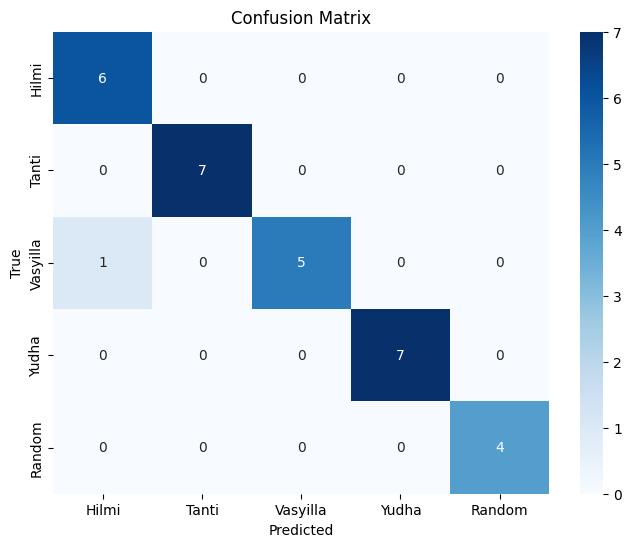

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_ovo)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hilmi', 'Tanti', 'Vasyilla', 'Yudha', 'Random'], yticklabels=['Hilmi', 'Tanti', 'Vasyilla', 'Yudha', 'Random'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix 4.png')
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred_ovo)

# Hitung True Negatives (TN) untuk setiap kelas
TN = []
for i in range(len(cm)):
    temp = np.delete(cm, i, 0)  # hapus baris ke-i
    temp = np.delete(temp, i, 1)  # hapus kolom ke-i
    TN.append(np.sum(temp))

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', np.diag(cm))

print('\nTrue Negatives(TN) = ', TN)

print('\nFalse Positives(FP) = ', np.sum(cm, axis=0) - np.diag(cm))

print('\nFalse Negatives(FN) = ', np.sum(cm, axis=1) - np.diag(cm))


Confusion matrix

 [[6 0 0 0 0]
 [0 7 0 0 0]
 [1 0 5 0 0]
 [0 0 0 7 0]
 [0 0 0 0 4]]

True Positives(TP) =  [6 7 5 7 4]

True Negatives(TN) =  [23, 23, 24, 23, 26]

False Positives(FP) =  [1 0 0 0 0]

False Negatives(FN) =  [0 0 1 0 0]


Classification Accuracy

In [ ]:
cm = confusion_matrix(y_test, y_pred_ovo)

# Hitung True Positives (TP) untuk setiap kelas
TP = np.diag(cm)

TN = []
FP = []
FN = []
for i in range(len(cm)):
    temp = np.delete(cm, i, 0)  # hapus baris ke-i
    temp = np.delete(temp, i, 1)  # hapus kolom ke-i
    TN.append(np.sum(np.delete(np.delete(cm, i, 0), i, 1)))
    FP.append(np.sum(cm[:, i]) - cm[i, i])
    FN.append(np.sum(cm[i, :]) - cm[i, i])

# Hitung total TP, TN, FP, FN
total_TP = np.sum(TP)
total_TN = np.sum(TN)
total_FP = np.sum(FP)
total_FN = np.sum(FN)

# Cetak total
print(f"Total True Positives (TP): {total_TP}")
print(f"Total True Negatives (TN): {total_TN}")
print(f"Total False Positives (FP): {total_FP}")
print(f"Total False Negatives (FN): {total_FN}")

Total True Positives (TP): 29
Total True Negatives (TN): 119
Total False Positives (FP): 1
Total False Negatives (FN): 1


In [ ]:
# Hitung True Positives (TP) untuk setiap kelas
TP = np.diag(cm)

# Hitung True Negatives (TN), False Positives (FP), dan False Negatives (FN) untuk setiap kelas
TN = []
FP = []
FN = []
for i in range(len(cm)):
    temp = np.delete(cm, i, 0)  # hapus baris ke-i
    temp = np.delete(temp, i, 1)  # hapus kolom ke-i
    TN.append(np.sum(np.delete(np.delete(cm, i, 0), i, 1)))
    FP.append(np.sum(cm[:, i]) - cm[i, i])
    FN.append(np.sum(cm[i, :]) - cm[i, i])

# Cetak hasil
for i in range(len(cm)):
    print(f"Kelas {i}:")
    print(f"True Negatives (TN): {TN[i]}, False Positives (FP): {FP[i]}, False Negatives (FN): {FN[i]}, True Positives (TP): {TP[i]}")
    print()

Kelas 0:
True Negatives (TN): 31, False Positives (FP): 1, False Negatives (FN): 0, True Positives (TP): 13

Kelas 1:
True Negatives (TN): 36, False Positives (FP): 0, False Negatives (FN): 0, True Positives (TP): 9

Kelas 2:
True Negatives (TN): 36, False Positives (FP): 0, False Negatives (FN): 1, True Positives (TP): 8

Kelas 3:
True Negatives (TN): 35, False Positives (FP): 0, False Negatives (FN): 0, True Positives (TP): 10

Kelas 4:
True Negatives (TN): 41, False Positives (FP): 0, False Negatives (FN): 0, True Positives (TP): 4



In [ ]:
# Hitung True Positives (TP) untuk setiap kelas
TP = np.diag(cm)

# Hitung True Negatives (TN), False Positives (FP), dan False Negatives (FN) untuk setiap kelas
TN = []
FP = []
FN = []
for i in range(len(cm)):
    temp = np.delete(cm, i, 0)  # hapus baris ke-i
    temp = np.delete(temp, i, 1)  # hapus kolom ke-i
    TN.append(np.sum(np.delete(np.delete(cm, i, 0), i, 1)))
    FP.append(np.sum(cm[:, i]) - cm[i, i])
    FN.append(np.sum(cm[i, :]) - cm[i, i])

# Hitung classification accuracy
classification_accuracy = (np.sum(TP) + np.sum(TN)) / float(np.sum(TP) + np.sum(TN) + np.sum(FP) + np.sum(FN))

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.9867


In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 1.0000


Classification  Error

In [ ]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Precision

In [ ]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))

Recall

In [ ]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 1.0000


F1-Score

In [ ]:
# F1-score untuk model dengan kernel RBF
f1_score_rbf = f1_score(y_test, y_pred_ovo, average='weighted')
print("F1-score:", f1_score_rbf)

F1-score: 0.9832053251408089
